# 1.BDMLtools分箱算法介绍并与scorecardpy对比  <font size=3 >by 曾珂</font>

**环境**:
+ **OS**: macOS Big Sur 11.5.2
+ **CPU**: 2GHz 四核Intel Core i5
+ **内存**: 16G

In [1]:
import scorecardpy as sc
import BDMLtools as bm
import pandas as pd
import numpy as np

In [2]:
bm.__version__

'0.3.8'

In [3]:
sc.__version__

'0.1.9.7'

In [4]:
pd.__version__

'1.5.3'

+ load germancredit data

In [5]:
dt=sc.germancredit().copy()
dt['creditability']=dt['creditability'].map({'good':0,'bad':1})

+ 将germancredit的有序category类型转换为有序数值类型
+ bm.dtypeAllocator作用在于分配指定列类型至number和object两种类型并限制数据精度
    + bm库的分箱及评分卡制作限于这两种类型

In [6]:
da=bm.dtypeAllocator().fit(dt)
dt=da.transform(dt)

In [7]:
X=dt.drop('creditability',axis=1)
y=dt['creditability']

## 1.1 分箱对比

### 1.1.1 分箱-tree

总结:

+ BDMLtools的tree分箱的底层使用numpy并按照scorecardpy分箱逻辑进行了重写
+ tree最优分箱中两者的分箱结果大体一致,在一些细节上有不同
+ BDMLtools的tree分箱运行效率更佳
+ scorecardpy使用mutilprocessing完成列处理的并行,BDMLtools则使用joblib完成列处理的并行

+ scorecardpy

scorecardpy目前已停止更新，其不支持pandas的较新版本，本代码环境使用的pandas版本为1.3.5

In [8]:
%%time
bins_sc = sc.woebin(dt, y = "creditability",method="tree",bin_num_limit=5,count_distr_limit=0.05,no_cores=1)

[INFO] creating woe binning ...
CPU times: user 3.39 s, sys: 38.2 ms, total: 3.43 s
Wall time: 3.46 s


+ BDMLtools

In [9]:
%%time
bins_bm=bm.binSelector(method='tree',bin_num_limit=5,distr_limit=0.05,iv_limit=0,n_jobs=1).fit(X,y).bins

CPU times: user 777 ms, sys: 20.7 ms, total: 797 ms
Wall time: 824 ms


+ 对比结果

In [10]:
bins_sc['credit_amount']

,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,credit_amount,"[-inf,1400.0)",267,0.267,185,82,0.307116,0.033661,0.000305,0.18122,1400.0,False
1,credit_amount,"[1400.0,1800.0)",105,0.105,87,18,0.171429,-0.728239,0.046815,0.18122,1800.0,False
2,credit_amount,"[1800.0,4000.0)",382,0.382,287,95,0.248691,-0.258307,0.024109,0.18122,4000.0,False
3,credit_amount,"[4000.0,9200.0)",196,0.196,120,76,0.387755,0.390539,0.031987,0.18122,9200.0,False
4,credit_amount,"[9200.0,inf)",50,0.050,21,29,0.580000,1.170071,0.078005,0.18122,inf,False


In [11]:
bins_bm['credit_amount']

,variable,count,count_distr,good,bad,badprob,woe,total_iv,breaks
bin,,,,,,,,,
"[-inf, 1400.0)",credit_amount,267,0.267,185.0,82.0,0.307116,0.033661,0.18122,1400.0
"[1400.0, 1800.0)",credit_amount,105,0.105,87.0,18.0,0.171429,-0.728239,0.18122,1800.0
"[1800.0, 4000.0)",credit_amount,382,0.382,287.0,95.0,0.248691,-0.258307,0.18122,4000.0
"[4000.0, 9200.0)",credit_amount,196,0.196,120.0,76.0,0.387755,0.390539,0.18122,9200.0
"[9200.0, inf)",credit_amount,50,0.050,21.0,29.0,0.580000,1.170071,0.18122,inf
special,credit_amount,0,0.000,0.0,0.0,NaN,0.000000,0.18122,special
missing,credit_amount,0,0.000,0.0,0.0,NaN,0.000000,0.18122,missing


+ iv对比

In [12]:
pd.concat(
    [pd.concat(bins_sc).groupby('variable')['bin_iv'].sum().rename('iv_sc'),
     pd.concat(bins_bm).groupby('variable')['total_iv'].max().rename('iv_bm')],axis=1
)

,iv_sc,iv_bm
variable,,
age_in_years,0.130499,1.304985e-01
credit_amount,0.181220,1.812204e-01
credit_history,0.291830,2.918299e-01
duration_in_month,0.282618,2.826181e-01
foreign_worker,0.000000,3.227801e-13
housing,0.083293,8.329343e-02
installment_rate_in_percentage_of_disposable_income,0.025569,2.632209e-02
job,0.008095,8.095050e-03
number_of_existing_credits_at_this_bank,0.010084,1.008356e-02


### 1.1.2 分箱chi2merge

+ BDMLtools的chi2分箱的底层使用numpy并按照scorecardpy的分箱逻辑进行了重写
+ chi2分箱中两者的分箱结果大体一致,部分不一致在于BDMLtools修复了scorecardpy中卡方分箱的breaks与bin对应不一致问题
+ BDMLtools的chi2分箱运行效率更佳
+ scorecardpy使用mutilprocessing完成列处理的并行,BDMLtools则使用joblib完成列处理的并行

In [13]:
%%time
bins_sc_chi = sc.woebin(dt, y = "creditability",method="chimerge",bin_num_limit=5,count_distr_limit=0.05,no_cores=1)

[INFO] creating woe binning ...
CPU times: user 5.74 s, sys: 89.2 ms, total: 5.83 s
Wall time: 5.97 s


In [14]:
%%time
bins_bm_chi=bm.binSelector(method='chi2',bin_num_limit=5,distr_limit=0.05,iv_limit=0,n_jobs=1).fit(X,y).bins

CPU times: user 1.17 s, sys: 6.72 ms, total: 1.18 s
Wall time: 1.18 s


In [15]:
bins_sc_chi['age_in_years']

,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,[[[[array([array([array([array([array([array([...,"[-inf,26.0)",190,0.190,110,80,0.421053,0.528844,0.057921,0.123935,26.0,False
1,[[[[array([array([array([array([array([array([...,"[26.0,35.0)",358,0.358,246,112,0.312849,0.060465,0.001324,0.123935,35.0,False
2,[[[[array([array([array([array([array([array([...,"[35.0,37.0)",79,0.079,67,12,0.151899,-0.872488,0.048610,0.123935,37.0,False
3,[[[[array([array([array([array([array([array([...,"[37.0,inf)",373,0.373,277,96,0.257373,-0.212371,0.016080,0.123935,inf,False


In [16]:
bins_bm_chi['age_in_years']

,variable,count,count_distr,good,bad,badprob,woe,total_iv,breaks
bin,,,,,,,,,
"[-inf, 26.0)",age_in_years,190.0,0.190,110.0,80.0,0.421053,0.528844,0.123935,26.0
"[26.0, 35.0)",age_in_years,358.0,0.358,246.0,112.0,0.312849,0.060465,0.123935,35.0
"[35.0, 37.0)",age_in_years,79.0,0.079,67.0,12.0,0.151899,-0.872488,0.123935,37.0
"[37.0, inf)",age_in_years,373.0,0.373,277.0,96.0,0.257373,-0.212371,0.123935,inf
special,age_in_years,0.0,0.000,0.0,0.0,NaN,0.000000,0.123935,special
missing,age_in_years,0.0,0.000,0.0,0.0,NaN,0.000000,0.123935,missing


In [17]:
# pd.concat(
#     [pd.concat(bins_sc_chi).groupby('variable')['bin_iv'].sum().rename('iv_sc'),
#      pd.concat(bins_bm_chi).groupby('variable')['total_iv'].max().rename('iv_bm')],axis=1
# )

### 1.1.3 交互式分箱

+ scorecardpy使用sc.woebin_adj进行交互式分箱
+ BDMLtools使用binAdjuster进行交互式分箱，其使用方法与scorecardpy一致

[INFO] creating woe binning ...
-------- 1/2 age_in_years --------
>>> dt[age_in_years].describe(): 
count    1000.000000
mean       35.546000
std        11.375469
min        19.000000
25%        27.000000
50%        33.000000
75%        42.000000
max        75.000000
Name: age_in_years, dtype: float64 



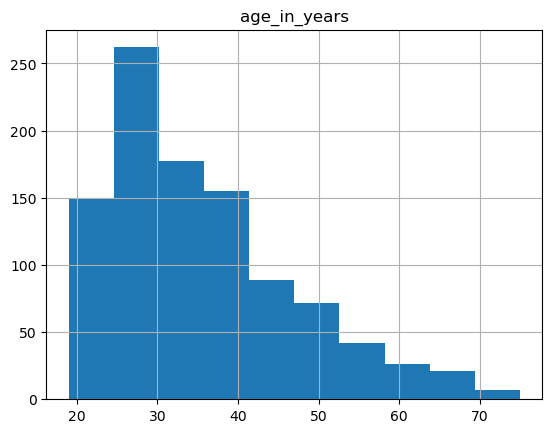

>>> Current breaks:
26.0,28.0,35.0,37.0 



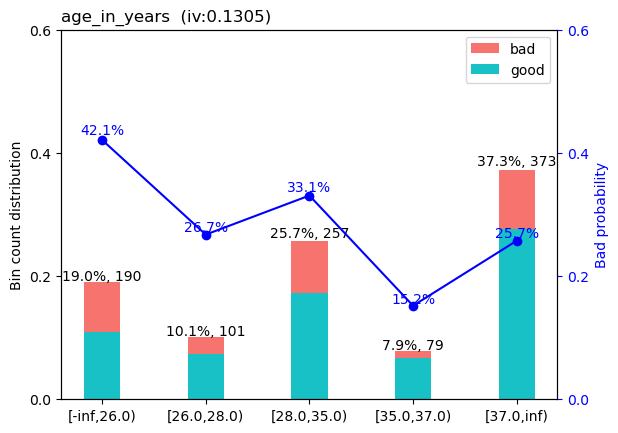

>>> Adjust breaks for (1/2) age_in_years?
1: next 
2: yes 
3: back
Selection: 1
-------- 2/2 credit_amount --------
>>> dt[credit_amount].describe(): 
count     1000.000000
mean      3271.258000
std       2822.736876
min        250.000000
25%       1365.500000
50%       2319.500000
75%       3972.250000
max      18424.000000
Name: credit_amount, dtype: float64 



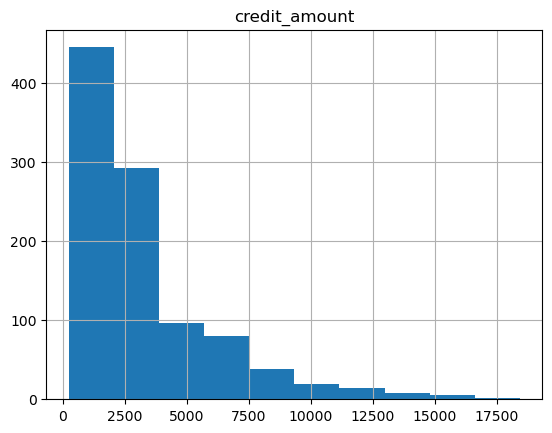

>>> Current breaks:
1400.0,1800.0,4000.0,9200.0 



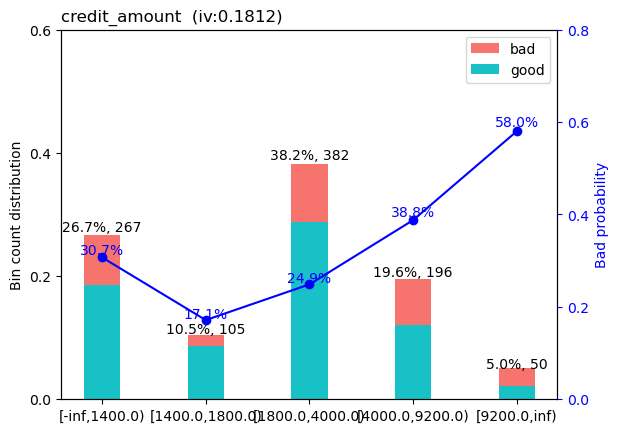

>>> Adjust breaks for (2/2) credit_amount?
1: next 
2: yes 
3: back
Selection: 1
{'age_in_years': [26.0,28.0,35.0,37.0], 'credit_amount': [1400.0,1800.0,4000.0,9200.0]}


In [18]:
dt_1 = dt[["creditability", "age_in_years", "credit_amount"]]
bins = sc.woebin(dt_1, y="creditability")
breaks_adj = sc.woebin_adj(dt_1, y="creditability", bins=bins)
print(breaks_adj)

+ 与scorecardpy不同，binAdjuster的输入参数为breaks_list,方法fit后接X与y即可开始交互分箱

----Adjusting age_in_years...----
Current breaks: [26.0, 28.0, 35.0, 37.0]...


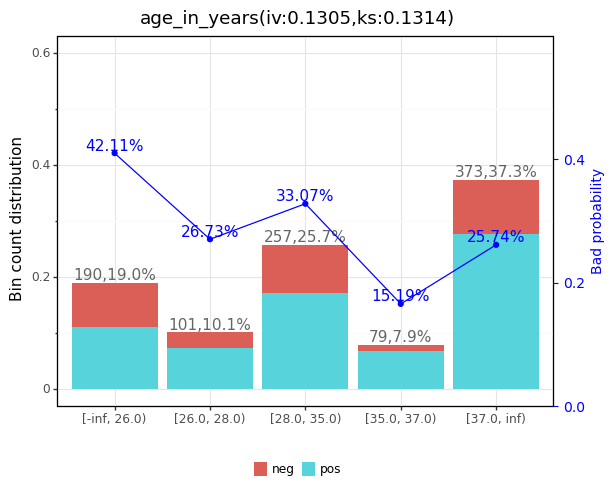

>>> Adjust breaks for (1/2) age_in_years?
1: next 
2: yes 
3: back 
4: remove 
0: exit
Selection: 1
----Adjusting age_in_years finish.----
----Adjusting credit_amount...----
Current breaks: [1400.0, 1800.0, 4000.0, 9200.0]...


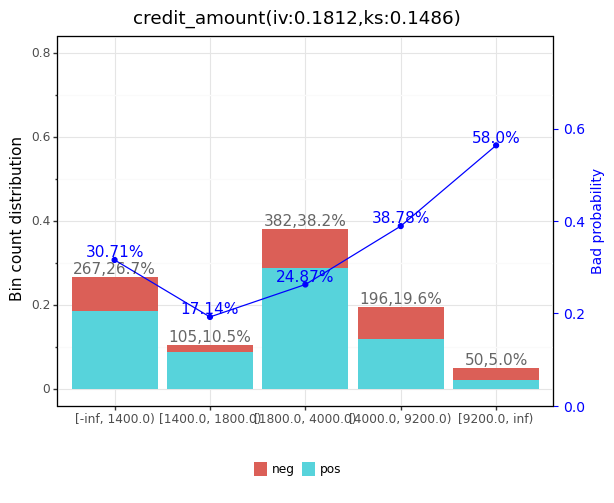

>>> Adjust breaks for (2/2) credit_amount?
1: next 
2: yes 
3: back 
4: remove 
0: exit
Selection: 1
----Adjusting credit_amount finish.----
Adjustion complete...
{'age_in_years': [26.0, 28.0, 35.0, 37.0], 'credit_amount': [1400.0, 1800.0, 4000.0, 9200.0]}


In [19]:
breaks_list={'age_in_years': [26.0,28.0,35.0,37.0], 
             'credit_amount': [1400.0,1800.0,4000.0,9200.0]}
bin_adj=bm.binAdjuster(breaks_list).fit(X,y)
print(bin_adj.breaks_list_adj)

## 1.2 BDMLtools的补充

### 1.2.1 BDMLtools对scorecardpy分箱算法的补充1:更多的分箱算法

bm.binSelector的method:
+ ‘freq’:数值等频分箱，分类特征按其类别分箱
+ ‘freq-kmeans’:基于Kmeans，对freq-cut结果进行自动调整，以将badrate近似的箱进行合并
+ 'pretty':使用Pretty Breakpoints获取数值特征分箱点
    + pretty分箱点更加美观，适合报告、绘图
    + 详见R的pretty函数           
+ 'tree':决策树,分裂iv/ks增益最高的切分点形成新分箱直到达到终止条件
+ 'chi2':卡方,先进行预分箱,再合并低于卡方值(交叉表卡方检验的差异不显著)的分箱

#### 1.2.1.1 等频

In [20]:
bin_freq=bm.binSelector(method='freq',bin_num_limit=5,iv_limit=0,n_jobs=1).fit(X,y).bins

In [21]:
bin_freq['age_in_years']

,variable,count,count_distr,good,bad,badprob,woe,total_iv,breaks
bin,,,,,,,,,
"[-inf, 26.0)",age_in_years,190,0.190,110.0,80.0,0.421053,0.528844,0.087812,26.0
"[26.0, 30.0)",age_in_years,181,0.181,124.0,57.0,0.314917,0.070068,0.087812,30.0
"[30.0, 36.0)",age_in_years,217,0.217,156.0,61.0,0.281106,-0.091684,0.087812,36.0
"[36.0, 45.0)",age_in_years,211,0.211,159.0,52.0,0.246445,-0.270363,0.087812,45.0
"[45.0, inf)",age_in_years,201,0.201,151.0,50.0,0.248756,-0.257959,0.087812,inf
special,age_in_years,0,0.000,0.0,0.0,NaN,0.000000,0.087812,special
missing,age_in_years,0,0.000,0.0,0.0,NaN,0.000000,0.087812,missing


#### 1.2.1.2 等频-kmeans分箱算法

In [22]:
bin_kmeans=bm.binSelector(method='freq-kmeans',max_bin=5,bin_num_limit=4,iv_limit=0,n_jobs=1).fit(X,y).bins

In [23]:
bin_kmeans['age_in_years']
#注意等频5箱中[36.0, 45.0)和[45.0, Inf)的badprob非常接近,此时算法自动合并了这两箱

,variable,count,count_distr,good,bad,badprob,woe,total_iv,breaks
bin,,,,,,,,,
"[-inf, 26.0)",age_in_years,190.0,0.190,110.0,80.0,0.421053,0.528844,0.087797,26.0
"[26.0, 30.0)",age_in_years,181.0,0.181,124.0,57.0,0.314917,0.070068,0.087797,30.0
"[30.0, 36.0)",age_in_years,217.0,0.217,156.0,61.0,0.281106,-0.091684,0.087797,36.0
"[36.0, inf)",age_in_years,412.0,0.412,310.0,102.0,0.247573,-0.264302,0.087797,inf
special,age_in_years,0.0,0.000,0.0,0.0,NaN,0.000000,0.087797,special
missing,age_in_years,0.0,0.000,0.0,0.0,NaN,0.000000,0.087797,missing


#### 1.2.1.3 pretty分箱

+ 对比freq分箱,pretty分箱会损失信息量但能够获取到美观的breaks
+ scorecardpy在卡方、决策树分箱的预分箱中都采用的是pretty分箱而非等频/等距等分箱,BDMLtools与scorecardpy一致

In [24]:
bin_pretty=bm.binSelector(method='pretty',bin_num_limit=5,distr_limit=0.05,iv_limit=0,n_jobs=1).fit(X,y).bins

In [25]:
bin_pretty['credit_amount']

,variable,count,count_distr,good,bad,badprob,woe,total_iv,breaks
bin,,,,,,,,,
"[-inf, 1800.0)",credit_amount,372.0,0.372,272.0,100.0,0.268817,-0.153334,0.086088,1800.0
"[1800.0, 2600.0)",credit_amount,181.0,0.181,129.0,52.0,0.287293,-0.061271,0.086088,2600.0
"[2600.0, 3400.0)",credit_amount,121.0,0.121,92.0,29.0,0.239669,-0.307195,0.086088,3400.0
"[3400.0, 5800.0)",credit_amount,165.0,0.165,117.0,48.0,0.290909,-0.043675,0.086088,5800.0
"[5800.0, inf)",credit_amount,161.0,0.161,90.0,71.0,0.440994,0.610168,0.086088,inf
special,credit_amount,0.0,0.000,0.0,0.0,NaN,0.000000,0.086088,special
missing,credit_amount,0.0,0.000,0.0,0.0,NaN,0.000000,0.086088,missing


In [26]:
bin_freq['credit_amount'] 

,variable,count,count_distr,good,bad,badprob,woe,total_iv,breaks
bin,,,,,,,,,
"[-inf, 1262.0)",credit_amount,198,0.198,137.0,61.0,0.308081,0.038191,0.096059,1262.0
"[1262.0, 1906.8)",credit_amount,202,0.202,154.0,48.0,0.237624,-0.318454,0.096059,1906.8
"[1906.8, 2852.4)",credit_amount,200,0.200,146.0,54.0,0.270000,-0.147325,0.096059,2852.4
"[2852.4, 4720.0)",credit_amount,200,0.200,148.0,52.0,0.260000,-0.198671,0.096059,4720.0
"[4720.0, inf)",credit_amount,200,0.200,115.0,85.0,0.425000,0.545017,0.096059,inf
special,credit_amount,0,0.000,0.0,0.0,NaN,0.000000,0.096059,special
missing,credit_amount,0,0.000,0.0,0.0,NaN,0.000000,0.096059,missing


### 1.2.2 BDMLtools对scorecardpy分箱算法的补充2:强制单调

bm.binSelector可以强制任意分箱算法实现数值特征的单调分箱,以tree为例
+ 参数coerce_monotonic=True即可实现单调分箱
+ 细节请查看binSelector的帮助文档

In [27]:
bin_monotonic=bm.binSelector(method='tree',bin_num_limit=5,distr_limit=0.05,
               iv_limit=0,n_jobs=1,coerce_monotonic=True).fit(X,y).bins

+ age.in.years

In [28]:
bin_monotonic['age_in_years']

,variable,count,count_distr,good,bad,badprob,woe,total_iv,breaks
bin,,,,,,,,,
"[-inf, 26.0)",age_in_years,190,0.190,110.0,80.0,0.421053,0.528844,0.100182,26.0
"[26.0, 30.0)",age_in_years,181,0.181,124.0,57.0,0.314917,0.070068,0.100182,30.0
"[30.0, 35.0)",age_in_years,177,0.177,122.0,55.0,0.310734,0.050610,0.100182,35.0
"[35.0, inf)",age_in_years,452,0.452,344.0,108.0,0.238938,-0.311213,0.100182,inf
special,age_in_years,0,0.000,0.0,0.0,NaN,0.000000,0.100182,special
missing,age_in_years,0,0.000,0.0,0.0,NaN,0.000000,0.100182,missing


+ credit.amount

In [29]:
bin_monotonic['credit_amount']

,variable,count,count_distr,good,bad,badprob,woe,total_iv,breaks
bin,,,,,,,,,
"[-inf, 4000.0)",credit_amount,754,0.754,559.0,195.0,0.258621,-0.205852,0.141682,4000.0
"[4000.0, 6800.0)",credit_amount,133,0.133,83.0,50.0,0.375940,0.340480,0.141682,6800.0
"[6800.0, 9200.0)",credit_amount,63,0.063,37.0,26.0,0.412698,0.494476,0.141682,9200.0
"[9200.0, inf)",credit_amount,50,0.050,21.0,29.0,0.580000,1.170071,0.141682,inf
special,credit_amount,0,0.000,0.0,0.0,NaN,0.000000,0.141682,special
missing,credit_amount,0,0.000,0.0,0.0,NaN,0.000000,0.141682,missing


In [30]:
#所有变量的效果
##字符类特征(purpose)是否单调意义不大,可忽略其单调性结果
bin_monotonic=bm.binSelector(method='tree',bin_num_limit=5,distr_limit=0.05,
               iv_limit=0,n_jobs=1,coerce_monotonic=True).fit(X,y).bins

for key in bin_monotonic:
    
    vtab=bin_monotonic[key]
    
    badprob=vtab.loc[~vtab.index.isin(['missing','special'])]['badprob']
    
    if badprob.is_monotonic_decreasing or badprob.is_monotonic_increasing:
        
        print('monotonic trend shows in {}'.format(key))
    
    else:
        
        print('no monotonic trend shows in {}'.format(key))

monotonic trend shows in age_in_years
monotonic trend shows in credit_amount
monotonic trend shows in credit_history
monotonic trend shows in duration_in_month
monotonic trend shows in foreign_worker
monotonic trend shows in housing
monotonic trend shows in installment_rate_in_percentage_of_disposable_income
monotonic trend shows in job
monotonic trend shows in number_of_existing_credits_at_this_bank
monotonic trend shows in number_of_people_being_liable_to_provide_maintenance_for
monotonic trend shows in other_debtors_or_guarantors
monotonic trend shows in other_installment_plans
monotonic trend shows in personal_status_and_sex
monotonic trend shows in present_employment_since
monotonic trend shows in present_residence_since
monotonic trend shows in property
monotonic trend shows in purpose
monotonic trend shows in savings_account_and_bonds
monotonic trend shows in status_of_existing_checking_account
monotonic trend shows in telephone


### 1.2.3 BDMLtools对scorecardpy分箱算法的补充3:样本权重

若数据是经过抽样获取的，一般希望通过样本加权建模以利于还原其违约概率、ln(好坏比)等指标。
+ 加入样本权重后各个分箱的坏样本率会产生一定变化
+ 加入样本权重后各个分箱的iv,ks也会产生变化(若只对好坏样本加权且breaks一致则无变化)
+ 在分箱算法中样本权重的影响如下:
    + 每一箱的样本数会产生一定变化,进而影响箱样本量。
        + 例如卡方分箱的交叉表频数统计会产生变化进而影响卡方值的计算结果
        + 影响通过每箱最小样本比例控制的任何分箱算法的结果
    + 坏样本率会产生一定变化,进而影响单调分箱结果
    + iv,ks等会产生一定变化,进而影响tree最优分箱结果
    
总之加入样本权重的分箱算法会更加精准的给出breaks

#### 1.2.3.1 例:加入样本权重后的卡方分箱结果

In [31]:
sample_weight=y.map({0:10,1:1}) #假定数据经过抽样后好样本权重为10,坏样本权重为1

In [32]:
#无加权(卡方分箱)
bin_nw=bm.binSelector(method='chi2',bin_num_limit=5,distr_limit=0.05,n_jobs=1,sample_weight=None).fit(X,y).bins

In [33]:
#有加权(卡方分箱)
bin_w=bm.binSelector(method='chi2',bin_num_limit=5,distr_limit=0.05,n_jobs=1,sample_weight=sample_weight).fit(X,y).bins

In [34]:
bin_nw['credit_amount']

,variable,count,count_distr,good,bad,badprob,woe,total_iv,breaks
bin,,,,,,,,,
"[-inf, 1400.0)",credit_amount,267.0,0.267,185.0,82.0,0.307116,0.033661,0.114711,1400.0
"[1400.0, 1800.0)",credit_amount,105.0,0.105,87.0,18.0,0.171429,-0.728239,0.114711,1800.0
"[1800.0, 4400.0)",credit_amount,407.0,0.407,298.0,109.0,0.267813,-0.158448,0.114711,4400.0
"[4400.0, inf)",credit_amount,221.0,0.221,130.0,91.0,0.411765,0.490623,0.114711,inf
special,credit_amount,0.0,0.000,0.0,0.0,NaN,0.000000,0.114711,special
missing,credit_amount,0.0,0.000,0.0,0.0,NaN,0.000000,0.114711,missing


In [35]:
bin_w['credit_amount']

,variable,count,count_distr,good,bad,badprob,woe,total_iv,breaks
bin,,,,,,,,,
"[-inf, 1400.0)",credit_amount,1932,0.264658,1850.0,82.0,0.042443,0.033661,0.16421,1400.0
"[1400.0, 1800.0)",credit_amount,888,0.121644,870.0,18.0,0.020270,-0.728239,0.16421,1800.0
"[1800.0, 2000.0)",credit_amount,411,0.056301,390.0,21.0,0.051095,0.228259,0.16421,2000.0
"[2000.0, 3800.0)",credit_amount,2346,0.321370,2280.0,66.0,0.028133,-0.392393,0.16421,3800.0
"[3800.0, inf)",credit_amount,1723,0.236027,1610.0,113.0,0.065583,0.493281,0.16421,inf
special,credit_amount,0,0.000000,0.0,0.0,NaN,0.000000,0.16421,special
missing,credit_amount,0,0.000000,0.0,0.0,NaN,0.000000,0.16421,missing


### BDMLtools对scorecardpy分箱算法的补充4:分组交互式分箱

+ binAdjuster不仅可提供类似于sc.woe_adj的特征交互分箱功能，也可以提供分组的特征交互分箱功能
+ 参数column用于指定组变量名,其存在于X中,只支持一个组水平即参数column只能有一个组变量,这是考虑到性能与绘图的美观
+ figure_size可指定画布大小
+ sort_column可以指定绘图时的组排序
+ 支持sample_weight 
+ fit后的属性breaks_list_adj即为调整好的breaks_list

In [36]:
#模拟一个组变量
X['group']=pd.Series(np.random.randint(0,3,1000),name='group').map({0:'g1',1:'g2',2:'g3'})

----Adjusting age_in_years...----
Current breaks: [26.0, 28.0, 35.0, 37.0]...
[26.0, 28.0, 35.0, 37.0]
PSI at current breaks:[('g3', 0.005), ('g2', 0.0004), ('g1', 0.0079)]


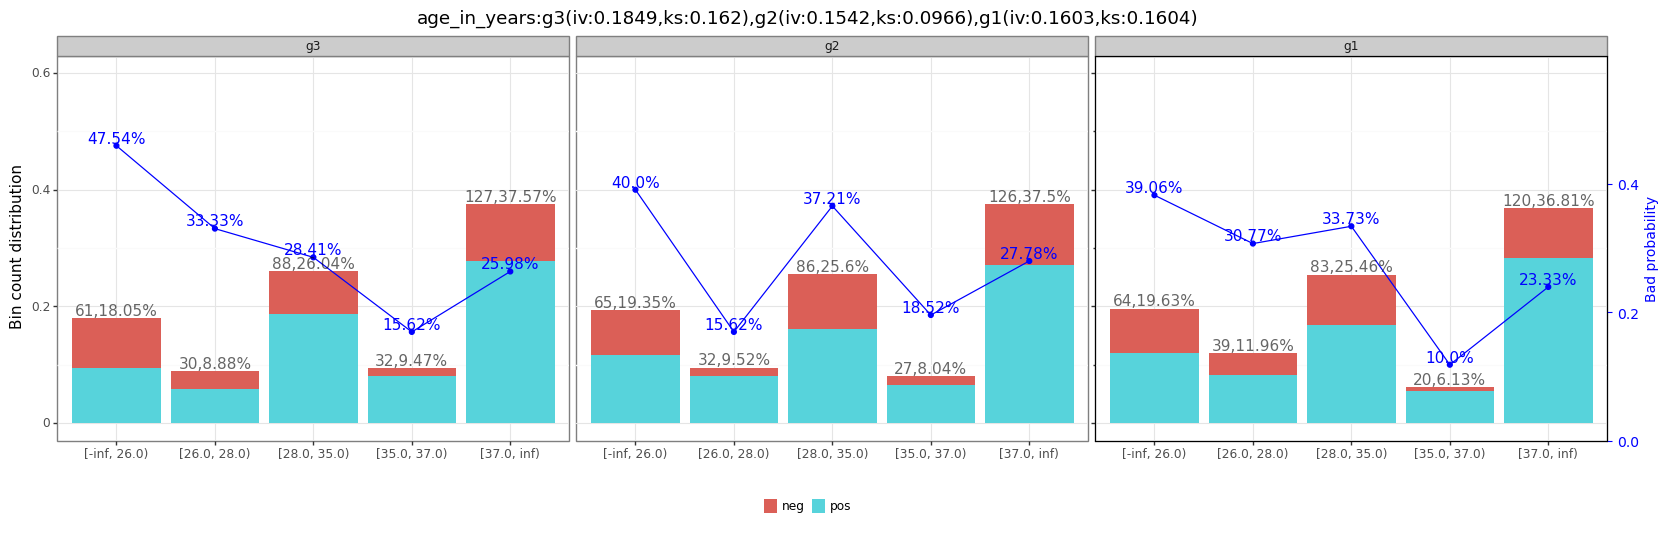

>>> Adjust breaks for (1/2) age_in_years?
1: next 
2: yes 
3: back 
4: remove 
0: exit
Selection: 1
----Adjusting age_in_years finish.----
----Adjusting credit_amount...----
Current breaks: [1400.0, 1800.0, 4000.0, 9200.0]...
[1400.0, 1800.0, 4000.0, 9200.0]
PSI at current breaks:[('g3', 0.0052), ('g2', 0.0049), ('g1', 0.0018)]


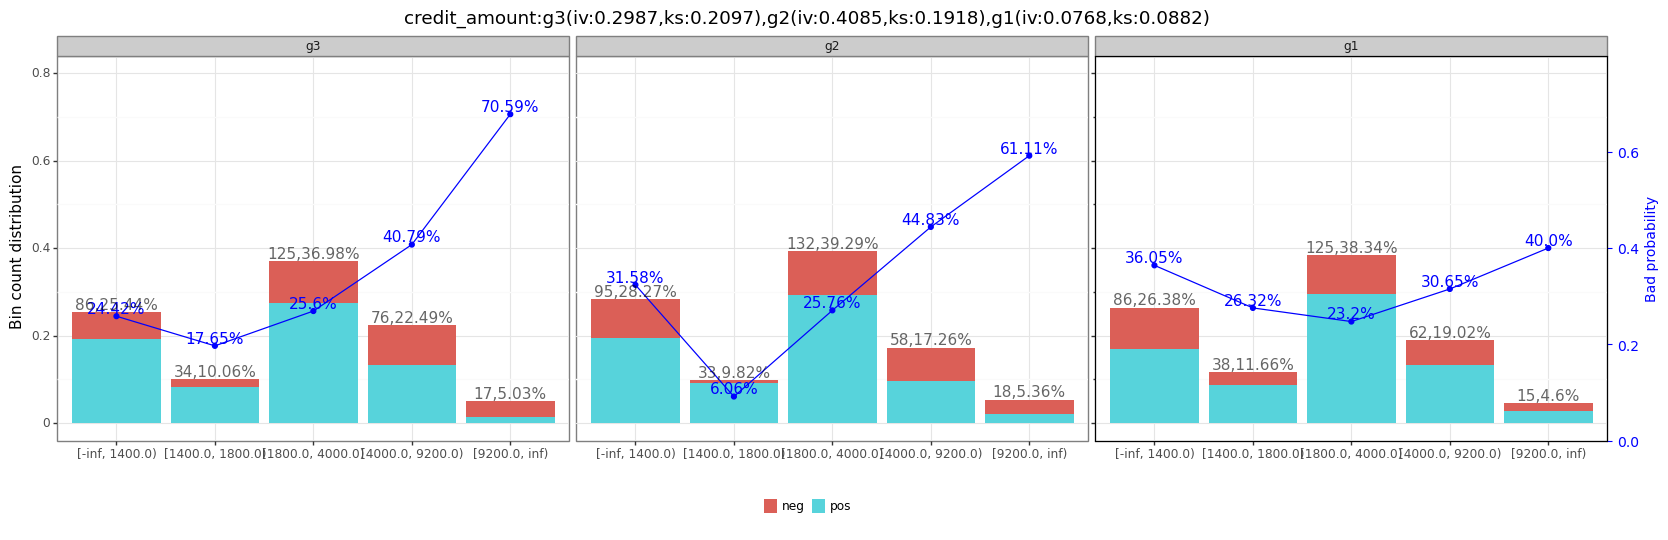

>>> Adjust breaks for (2/2) credit_amount?
1: next 
2: yes 
3: back 
4: remove 
0: exit
Selection: 1
----Adjusting credit_amount finish.----
Adjustion complete...


In [37]:
breaks_list={'age_in_years': [26.0,28.0,35.0,37.0],
             'credit_amount': [1400.0,1800.0,4000.0,9200.0]
            }
bin_adj=bm.binAdjuster(breaks_list,column='group',sort_column=['g3','g2','g1'],figure_size=(20,5)).fit(X,y)